In [1]:
import scanpy as sc
import numpy as np
import pandas as pd

In [2]:
adata = sc.read_h5ad('/home/tig687/regularizedSB/sc_data/sciPlex3_subset_10k.h5ad')

# Filter for MCF7 cell line AND Hesperadin treatment
h_subset = adata[
    (adata.obs['cell_type'] == 'MCF7') & 
    (adata.obs['product_name'] == 'Hesperadin')
].copy()

print(f"Found {h_subset.n_obs} cells for Hesperadin in MCF7.")

Found 964 cells for Hesperadin in MCF7.


In [3]:
h_subset.obs

,barcode,sample_id,orig_index,cell,sample,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,...,dose_pattern,dose_character,dose,treatment,pathway_level_1,pathway_level_2,product_name,target,pathway,n_genes
3,A01_E09_RT_BC_149_Lig_BC_370,Chem3_Screen2,587,A01_E09_RT_BC_149_Lig_BC_370,Chem3_Screen2,0.406242,686,454.0,0.0,0.0,...,4.0,10.0,10.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,512
9,A01_E09_RT_BC_175_Lig_BC_341,Chem3_Screen2,940,A01_E09_RT_BC_175_Lig_BC_341,Chem3_Screen2,0.731946,1236,51.0,0.0,0.0,...,2.0,1000.0,1000.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,902
15,A01_E09_RT_BC_18_Lig_BC_25,Chem3_Screen2,1156,A01_E09_RT_BC_18_Lig_BC_25,Chem3_Screen2,0.474936,802,217.0,0.0,0.0,...,4.0,10.0,10.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,574
20,A01_E09_RT_BC_238_Lig_BC_84,Chem3_Screen2,1767,A01_E09_RT_BC_238_Lig_BC_84,Chem3_Screen2,1.401120,2366,55.0,0.0,0.0,...,2.0,1000.0,1000.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,1365
73,A01_F10_RT_BC_201_Lig_BC_161,Chem3_Screen2,5713,A01_F10_RT_BC_201_Lig_BC_161,Chem3_Screen2,3.063988,5174,75.0,0.0,0.0,...,2.0,1000.0,1000.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,2253
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7922,H12_E09_RT_BC_114_Lig_BC_82,Chem3_Screen2,791464,H12_E09_RT_BC_114_Lig_BC_82,Chem3_Screen2,4.435499,7490,51.0,0.0,0.0,...,3.0,100.0,100.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,3009
7939,H12_E09_RT_BC_231_Lig_BC_69,Chem3_Screen2,793062,H12_E09_RT_BC_231_Lig_BC_69,Chem3_Screen2,0.617061,1042,35.0,0.0,0.0,...,4.0,10.0,10.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,798
7941,H12_E09_RT_BC_243_Lig_BC_113,Chem3_Screen2,793191,H12_E09_RT_BC_243_Lig_BC_113,Chem3_Screen2,0.361236,610,59.0,0.0,0.0,...,1.0,10000.0,10000.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,439
7951,H12_E09_RT_BC_326_Lig_BC_248,Chem3_Screen2,794181,H12_E09_RT_BC_326_Lig_BC_248,Chem3_Screen2,1.019158,1721,110.0,0.0,0.0,...,3.0,100.0,100.0,S1529,Cell cycle regulation,Aurora kinase activity,Hesperadin,Aurora Kinase,Cell Cycle,1004


In [4]:
# Filter for MCF7 cell line AND Vehicle (Control)
control_subset = adata[
    (adata.obs['cell_type'] == 'MCF7') & 
    (adata.obs['product_name'] == 'Vehicle')
].copy()

print(f"Found {control_subset.n_obs} cells for Vehicle (Control) in MCF7.")

Found 7034 cells for Vehicle (Control) in MCF7.


In [5]:
# 1. Prepare data for DE Analysis
# We want to compare MCF7 Hesperadin (Treated) vs MCF7 Vehicle (Control)
# Create a subset containing only these two conditions
de_adata = adata[
    (adata.obs['cell_type'] == 'MCF7') & 
    (adata.obs['product_name'].isin(['Vehicle', 'Hesperadin']))
].copy()

# 2. Preprocess (Normalize and Log Transform)
# Standard scRNA-seq normalization
sc.pp.normalize_total(de_adata, target_sum=1e4)
sc.pp.log1p(de_adata)

# 3. Run Differential Expression (Wilcoxon Rank-Sum)
# Compare 'Hesperadin' vs 'Vehicle'
print("Running differential expression analysis...")
sc.tl.rank_genes_groups(de_adata, groupby='product_name', reference='Vehicle', method='wilcoxon')

# 4. Extract Results
result = de_adata.uns['rank_genes_groups']
group = 'Hesperadin'

# These are var_names (e.g., Ensembl IDs or similar)
genes_idx = result['names'][group]
lfc = result['logfoldchanges'][group]
pvals_adj = result['pvals_adj'][group]

# Map to human-readable gene symbols if available
if 'gene_short_name' in de_adata.var.columns:
    gene_symbols = pd.Index(genes_idx).map(
        lambda g: de_adata.var.loc[g, 'gene_short_name'] if g in de_adata.var.index else g
    )
else:
    gene_symbols = genes_idx

# Create DataFrame with both ID and symbol
de_df = pd.DataFrame({
    'gene_id': genes_idx,       # original var_name
    'gene_symbol': gene_symbols,  # human-readable symbol (if available)
    'log2fc': lfc,
    'padj': pvals_adj,
})

print("Top 5 upregulated genes:")
print(
    de_df
    .sort_values('log2fc', ascending=False)
    [["gene_symbol", "gene_id", "log2fc", "padj"]]
    .head(5)
)

Running differential expression analysis...
Top 5 upregulated genes:
     gene_symbol            gene_id    log2fc      padj
667   AC129492.6  ENSG00000275011.1  4.837641  0.999953
1245      GUCY2C  ENSG00000070019.4  4.683630  0.999953
307         MGAM  ENSG00000257335.8  4.462990  0.389818
89    LHFPL3-AS2  ENSG00000225329.3  4.419423  0.006030
1367  AC007384.1  ENSG00000237513.1  4.133067  0.999953


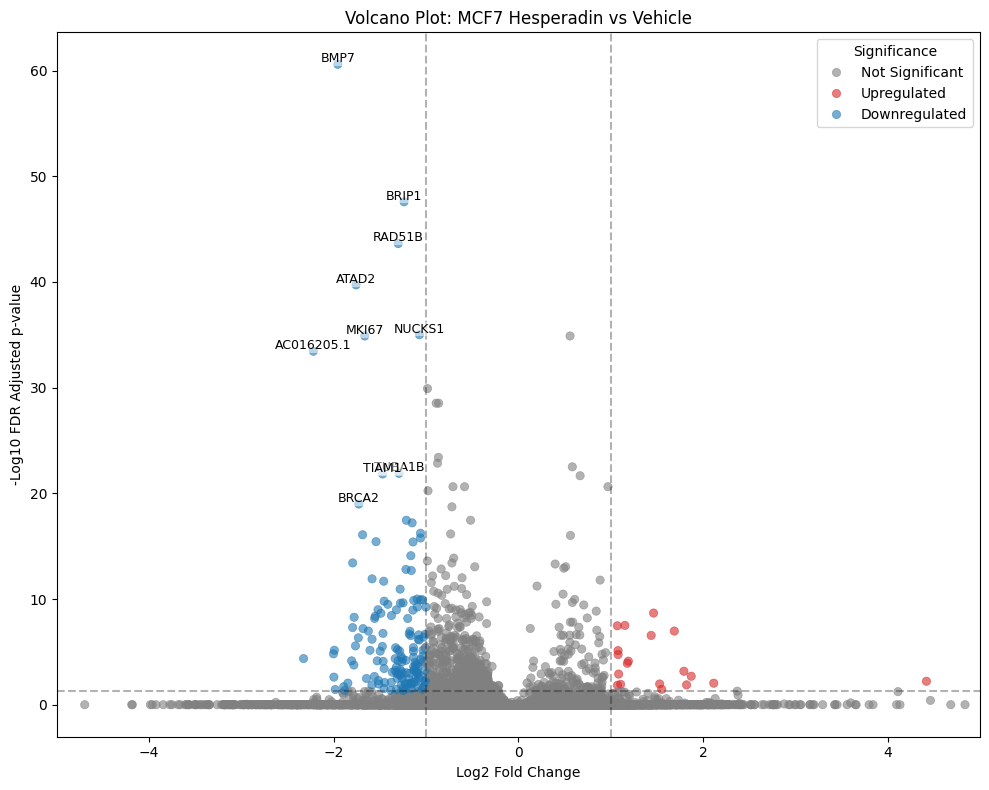

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 5. Volcano Plot
plt.figure(figsize=(10, 8))

# Calculate -log10(padj) for plotting
# Add a small epsilon to avoid log(0)
de_df['nlog10padj'] = -np.log10(de_df['padj'] + 1e-300)

# Define significance categories for coloring
de_df['color'] = 'Not Significant'
de_df.loc[(de_df['padj'] < 0.05) & (de_df['log2fc'] > 1), 'color'] = 'Upregulated'
de_df.loc[(de_df['padj'] < 0.05) & (de_df['log2fc'] < -1), 'color'] = 'Downregulated'

# Plot points
sns.scatterplot(
    data=de_df, 
    x='log2fc', 
    y='nlog10padj', 
    hue='color', 
    palette={'Not Significant': 'grey', 'Upregulated': '#d62728', 'Downregulated': '#1f77b4'},
    alpha=0.6,
    edgecolor=None
)

# Add threshold lines
plt.axvline(x=1, linestyle='--', color='black', alpha=0.3)
plt.axvline(x=-1, linestyle='--', color='black', alpha=0.3)
plt.axhline(y=-np.log10(0.05), linestyle='--', color='black', alpha=0.3)

# Label top significant genes (by adjusted p-value)
top_genes = de_df[de_df['color'] != 'Not Significant'].sort_values('padj').head(10)
for _, row in top_genes.iterrows():
    label = row.get('gene_symbol', row.get('gene_id', ''))
    plt.text(
        row['log2fc'], 
        row['nlog10padj'] + 0.2, 
        label, 
        fontsize=9, 
        ha='center',
        bbox=dict(facecolor='white', alpha=0.5, edgecolor='none', pad=0.5)
    )

plt.title('Volcano Plot: MCF7 Hesperadin vs Vehicle')
plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 FDR Adjusted p-value')
plt.xlim(-5, 5)
plt.legend(title='Significance')
plt.tight_layout()
plt.show()

In [7]:
# Compute L1 perturbation between mean Vehicle and mean Hesperadin cells

# First, get the raw (or normalized) expression matrices
# Using the same normalized data from DE analysis
vehicle_cells = de_adata[de_adata.obs['product_name'] == 'Vehicle']
hesperadin_cells = de_adata[de_adata.obs['product_name'] == 'Hesperadin']

# Compute mean expression per gene for each condition
mean_vehicle = np.array(vehicle_cells.X.mean(axis=0)).flatten()
mean_hesperadin = np.array(hesperadin_cells.X.mean(axis=0)).flatten()

# Compute perturbation vector
perturbation = mean_hesperadin - mean_vehicle

# L1 metrics
l1_total = np.sum(np.abs(perturbation))
l1_mean_per_gene = np.mean(np.abs(perturbation))
l2_total = np.linalg.norm(perturbation)

# Sparsity: how many genes have |perturbation| > threshold?
threshold = 0.2
n_nonzero = np.sum(np.abs(perturbation) > threshold)
sparsity_pct = 100.0 * n_nonzero / len(perturbation)

print("=" * 50)
print("L1 Perturbation: Mean Vehicle → Mean Hesperadin")
print("=" * 50)
print(f"Number of genes: {len(perturbation)}")
print(f"Number of Vehicle cells: {vehicle_cells.n_obs}")
print(f"Number of Hesperadin cells: {hesperadin_cells.n_obs}")
print()
print(f"Total L1 (sum of |Δ|): {l1_total:.4f}")
print(f"Mean L1 per gene: {l1_mean_per_gene:.4f}")
print(f"Total L2 norm: {l2_total:.4f}")
print()
print(f"Genes with |Δ| > {threshold}: {n_nonzero} / {len(perturbation)} ({sparsity_pct:.1f}%)")
print()

# Top 10 genes by absolute perturbation magnitude
top_idx = np.argsort(np.abs(perturbation))[::-1][:10]
print("Top 10 genes by |perturbation|:")
for i, idx in enumerate(top_idx):
    gene_name = de_adata.var_names[idx]
    if 'gene_short_name' in de_adata.var.columns:
        symbol = de_adata.var.iloc[idx]['gene_short_name']
    else:
        symbol = gene_name
    print(f"  {i+1}. {symbol}: Δ = {perturbation[idx]:+.4f}")

L1 Perturbation: Mean Vehicle → Mean Hesperadin
Number of genes: 16818
Number of Vehicle cells: 7034
Number of Hesperadin cells: 964

Total L1 (sum of |Δ|): 410.2990
Mean L1 per gene: 0.0244
Total L2 norm: 6.1944

Genes with |Δ| > 0.2: 169 / 16818 (1.0%)

Top 10 genes by |perturbation|:
  1. BMP7: Δ = -0.7542
  2. BRIP1: Δ = -0.7128
  3. MKI67: Δ = -0.5896
  4. RAD51B: Δ = -0.5852
  5. ATAD2: Δ = -0.5797
  6. NUCKS1: Δ = -0.5297
  7. CCND1: Δ = -0.4886
  8. EMP2: Δ = -0.4839
  9. AC016205.1: Δ = -0.4839
  10. SYNE2: Δ = -0.4629
